In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [9]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        max_action = Q[observation].argmax()
        nA = Q[observation].shape[0]
        greedy_policy = np.zeros((nA), dtype=np.float)
        greedy_policy[max_action] = 1
        
        return greedy_policy
    
    return policy_fn

In [14]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(float)
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for i_episodes in range(num_episodes):
        if i_episodes % 50000 == 0: print(i_episodes)
            
        observation = env.reset()

        # Generate an episode using target_policy:
        observations_list = []
        actions_list = []
        rewards_list = []
        observations_list.append(observation)   # t = 0
        for t in range(100):
            probs = behavior_policy(observation)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            observation, reward, done, _ = env.step(action)
            observations_list.append(observation)   # t + 1
            actions_list.append(action)   # t
            rewards_list.append(reward)   # t+1
            if done:
                break
                
        G = 0
        W = 1
        for start_t in range(len(actions_list)-1, -1, -1):    # T-1, T-2, ..., downto 0
            state, action = observations_list[start_t], actions_list[start_t]
            # Consider every-visit (state, action)
            if (state, action) not in C:
                C[(state, action)] = 0
                
            G = discount_factor * G + rewards_list[start_t]
            C[(state, action)] += W
            Q[state][action] += W / C[(state, action)] * (G - Q[state][action])
            if action != target_policy(state).argmax():
                break
            W /= behavior_policy(state)[action]
        
    return Q, target_policy

In [18]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

0
50000
100000
150000
200000
250000
300000
350000
400000
450000


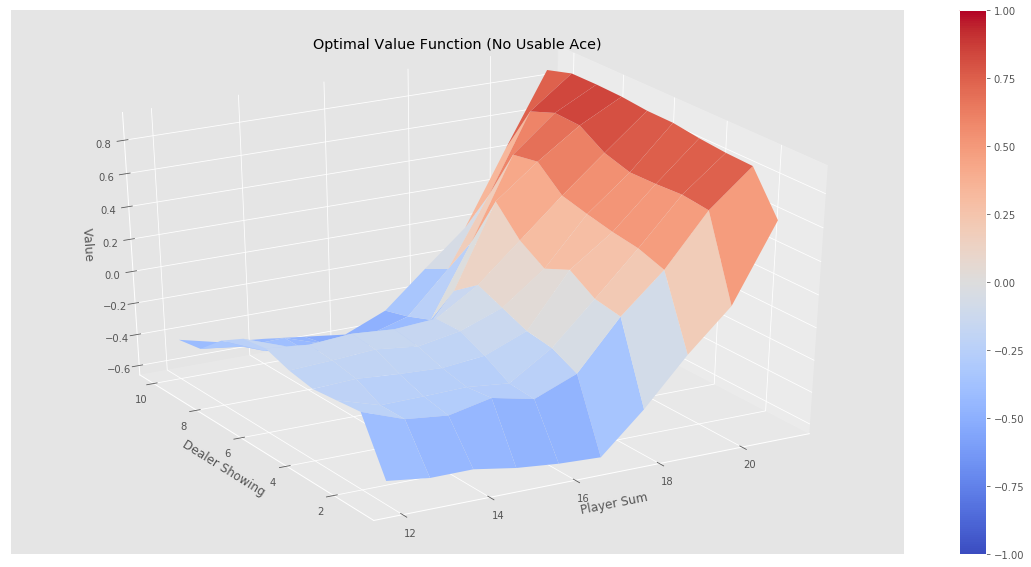

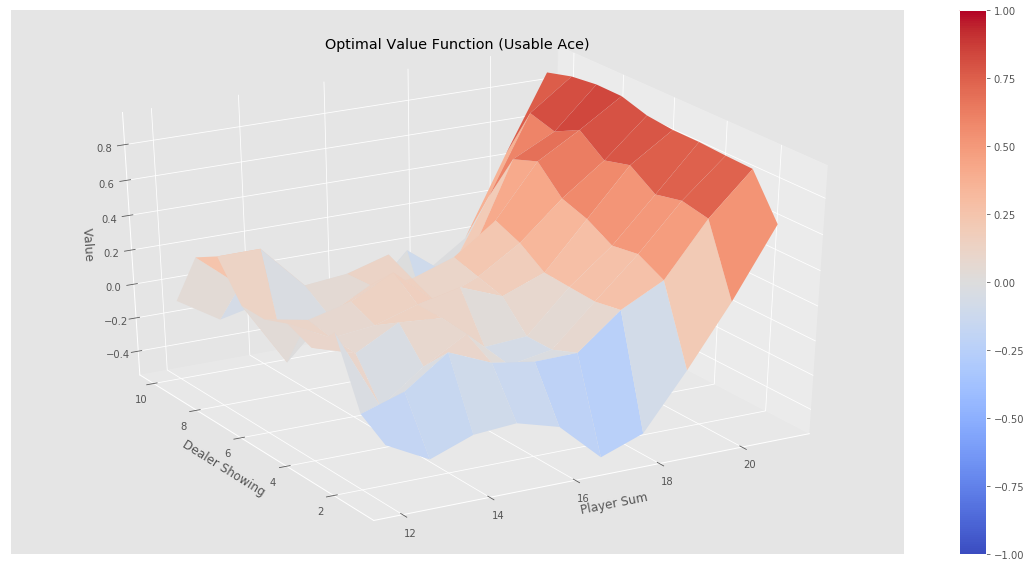

In [19]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")